In [1]:
# Various torch packages
import torch
import torch.nn as nn
import torch.nn.functional as F

# torchvision
from torchvision import datasets, transforms

# ------------------------
# get up one directory 
import sys, os
sys.path.append(os.path.abspath('../'))
# ------------------------

# custom packages
import models.aux_funs as maf
import optimizers as op
import regularizers as reg
import train
import math
import numpy as np
import time
import matplotlib.pyplot as plt
import utils.configuration as cf
import utils.datasets as ud
from models.mnist_conv import mnist_conv
from scipy.interpolate import make_interp_spline

# Fix the random seed

In [2]:
random_seed = 0
cf.seed_torch(random_seed)

# Configure the experiment

In [3]:
conf_args = {#
    # data specification
    'data_file':"../../datasets",'train_split':0.95, 'data_set':"Fashion-MNIST", 'download':True,
    # cuda
    'use_cuda':False, 'num_workers':2, 'cuda_device':0, 'pin_memory':True, 'train_split':0.95,
    #
    'epochs':5,
    # optimizer
    'delta':1.0, 'lr':0.1, 'lamda_0':1e-4, 'lamda_1':0.008, 'optim':"LinBreg", 'conv_group':True,
    'beta':0.9,
    # initialization
    'sparse_init':0.01, 'r':[10.,10.,10.],
    # misc
    'random_seed':random_seed, 'eval_acc':True,
}

conf = cf.Conf(**conf_args)

# Initiate the model

In [4]:
model_kwargs = {'mean':conf.data_set_mean, 'std':conf.data_set_std}    

model = mnist_conv(**model_kwargs)
best_model = train.best_model(mnist_conv(**model_kwargs).to(conf.device))

# Weight initialization

In [5]:
model_kwargs = {'mean':conf.data_set_mean, 'std':conf.data_set_std}    
def init_weights(conf, model):
    # sparsify
    maf.sparse_bias_uniform_(model, 0,conf.r[0])
    maf.sparse_bias_uniform_(model, 0,conf.r[0], ltype=torch.nn.Conv2d)
    maf.sparse_weight_normal_(model, conf.r[1])
    maf.sparse_weight_normal_(model, conf.r[2], ltype=torch.nn.Conv2d)
    #
    maf.sparsify_(model, conf.sparse_init, ltype = nn.Conv2d, conv_group=conf.conv_group)
    maf.sparsify_(model, conf.sparse_init, ltype = nn.Linear)
    model = model.to(conf.device)    
    return model

model = init_weights(conf,model)

# Optimizer

In [6]:
def init_opt(conf, model):
    # -----------------------------------------------------------------------------------
    # Get access to different model parameters
    # -----------------------------------------------------------------------------------
    weights_conv = maf.get_weights_conv(model)
    weights_linear = maf.get_weights_linear(model)
    biases = maf.get_bias(model)
    
    # -----------------------------------------------------------------------------------
    # Initialize optimizer
    # -----------------------------------------------------------------------------------
    if conf.conv_group:
        reg2 = reg.reg_l1_l2_conv(lamda=conf.lamda_0)
    else:
        reg2 = reg.reg_l1(lamda=conf.lamda_0)
    
    if conf.optim == "SGD":
        opt = torch.optim.SGD(model.parameters(), lr=conf.lr, momentum=conf.beta)
    elif conf.optim == "LinBreg": # change 'reg' to reg2 if want to use l1_l2 regularization as was previously
        opt = op.NuclearLinBreg([{'params': weights_conv, 'lr' : conf.lr, 'reg' : reg2, 'momentum':conf.beta,'delta':conf.delta},
                          # apply nuclear regularization to the conv layers, switch to l1 reg.reg_l1(lamda=conf.lamda_1) if needed
                          {'params': weights_linear, 'lr' : conf.lr, 'reg' : reg.reg_nuclear_linear_truncated(lamda=conf.lamda_1, rank=64), 'momentum':conf.beta,'delta':conf.delta},
                          {'params': biases, 'lr': conf.lr, 'momentum':conf.beta}])
    elif conf.optim == "ProxSGD":
        opt = op.ProxSGD([{'params': weights_conv, 'lr' : conf.lr, 'reg' : reg2, 'momentum':conf.beta,'delta':conf.delta},
                          {'params': weights_linear, 'lr' : conf.lr, 'reg' : reg.reg_nuclear_linear(lamda=conf.lamda_1), 'momentum':conf.beta,'delta':conf.delta},
                          {'params': biases, 'lr': conf.lr, 'momentum':conf.beta}])            
    elif conf.optim == "AdaBreg":
        opt = op.AdaBreg([{'params': weights_conv, 'lr' : conf.lr, 'reg' : reg.reg_nuclear_conv(lamda=conf.lamda_0),'delta':conf.delta},
                           {'params': weights_linear, 'lr' : conf.lr, 'reg' : reg.reg_l1(lamda=conf.lamda_1),'delta':conf.delta},
                           {'params': biases, 'lr': conf.lr}])
    elif conf.optim == "L1SGD":
        def weight_reg(model):
            reg1 =  reg.reg_l1(lamda=conf.lamda_1)
        
            loss1 = reg1(model.layers2[0].weight) + reg1(model.layers2[2].weight)
            loss2 = reg2(model.layers1[0].weight) + reg2(model.layers1[3].weight)
            return loss1 + loss2
        
        conf.weight_reg = weight_reg
        
        opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=beta)
    else:
        raise ValueError("Unknown Optimizer specified")

    # learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=5,threshold=0.01)
    
    return opt, scheduler

# Dataset

In [7]:
train_loader, valid_loader, test_loader = ud.get_data_set(conf)

# History and Runs

In [8]:
# Initialize history
tracked = ['loss', 'node_sparse']
train_hist = {}
val_hist = {}

# Training

In [9]:
# Add at the top of your training cell
import time

# -----------------------------------------------------------------------------------
# Reinit weights and the corresponding optimizer
# -----------------------------------------------------------------------------------
model = init_weights(conf, model)
opt, scheduler = init_opt(conf, model)

# Initialize history for tracking both metrics
effective_rank_histories = {}  # Dictionary to store rank history for each layer
test_accuracy_history = []

# Initialize timer variables
total_training_time = 0.0

# -----------------------------------------------------------------------------------
# train the model
# -----------------------------------------------------------------------------------
for epoch in range(conf.epochs):
    print(25*"<>")
    print(50*"|")
    print(25*"<>")
    print('Epoch:', epoch)
    
    # Start timer for this epoch
    epoch_start = time.time()

    # ------------------------------------------------------------------------
    # train step, log the accuracy and loss
    # ------------------------------------------------------------------------
    train_data = train.train_step(conf, model, opt, train_loader)

    # update history
    for key in tracked:
        if key in train_data:
            var_list = train_hist.setdefault(key, [])
            var_list.append(train_data[key])           

    # ------------------------------------------------------------------------
    # validation step
    # ------------------------------------------------------------------------
    val_data = train.validation_step(conf, model, opt, valid_loader)

    # Calculate and record time for this epoch
    epoch_time = time.time() - epoch_start
    total_training_time += epoch_time
    
    print(f"Epoch {epoch} training time: {epoch_time:.2f} seconds")
    print(f"Total training time so far: {total_training_time:.2f} seconds")
    
    # Rest of your code for tracking metrics (this doesn't count toward training time)
    # update validation history
    for key in tracked:
        if key in val_data:
            var = val_data[key]
            if isinstance(var, list):
                for i, var_loc in enumerate(var):
                    key_loc = key+"_" + str(i)
                    var_list = val_hist.setdefault(key_loc, [])
                    val_hist[key_loc].append(var_loc)
            else:
                var_list = val_hist.setdefault(key, [])
                var_list.append(var)   

    # Track effective rank ratio for each FC layer separately
    fc_layer_ranks = maf.get_linear_layer_ranks(model, epsilon=1e-3)
    for layer_name, rank_ratio in fc_layer_ranks.items():
        if layer_name not in effective_rank_histories:
            effective_rank_histories[layer_name] = []
        effective_rank_histories[layer_name].append(rank_ratio)
        print(f'Layer {layer_name} rank ratio (ε=1e-3): {rank_ratio:.4f}')
    
    # Also track test accuracy each epoch
    test_data = train.test(conf, model, test_loader, verbosity=0)
    test_accuracy_history.append(test_data['acc'])
    print(f'Test Accuracy: {test_data["acc"]:.4f}')

    scheduler.step(train_data['loss'])
    print("Learning rate:", opt.param_groups[0]['lr'])
    best_model(train_data['acc'], val_data['acc'], model=model)

# Print final timing information
print("\n" + "="*50)
print(f"Final total training time: {total_training_time:.2f} seconds")
print(f"Average time per epoch: {total_training_time/conf.epochs:.2f} seconds")
print("="*50)

<><><><><><><><><><><><><><><><><><><><><><><><><>
||||||||||||||||||||||||||||||||||||||||||||||||||
<><><><><><><><><><><><><><><><><><><><><><><><><>
Epoch: 0
--------------------------------------------------
Train Accuracy: 0.6846842105263158
Train Loss: 389.454382956028
--------------------------------------------------
Validation Accuracy: 0.7236666666666667
Non-zero kernels: 0.7975961538461539
Linear sparsity: 0.9574468085106383
Overall sparsity: 0.8871090576766856
Node sparsity: [1.0, 1.0]
Regularization values per group: [0.09648589324951172, tensor(0.7643), 0.0]
Epoch 0 training time: 21.40 seconds
Total training time so far: 21.40 seconds
Layer layers2.0 rank ratio (ε=1e-3): 0.5000
Layer layers2.2 rank ratio (ε=1e-3): 1.0000
Test Accuracy: 0.7232
Learning rate: 0.1
<><><><><><><><><><><><><><><><><><><><><><><><><>
||||||||||||||||||||||||||||||||||||||||||||||||||
<><><><><><><><><><><><><><><><><><><><><><><><><>
Epoch: 1
--------------------------------------------------

# Evaluation

In [10]:
train.test(conf, best_model.best_model, test_loader) 
print(f'Convolution kernel sparsity: {maf.conv_sparsity(best_model.best_model)}')
print(f'Linear sparsity: {maf.linear_sparsity(best_model.best_model)}')
linear_rank_ratio = maf.linear_effective_rank_ratio(best_model.best_model, epsilon=1e-3)
print(f'Linear Layer Effective Rank Ratio (ε=1e-3): {linear_rank_ratio}')
fc_layer_ranks = maf.get_linear_layer_ranks(best_model.best_model, epsilon=1e-3)
for layer_name, rank_ratio in fc_layer_ranks.items():
    print(f'Layer {layer_name} rank ratio (ε=1e-3): {fc_layer_ranks[layer_name]}')
print("\nSingular values of linear layers:")
for name, m in best_model.best_model.named_modules():
    if isinstance(m, torch.nn.Linear):
        _, S, _ = torch.svd(m.weight, some=True)
        print(f"Layer {name} singular values: {S[:10]}")  # Show first 10 values

--------------------------------------------------
Test Accuracy: 0.8101
Convolution kernel sparsity: 0.8276442307692308
Linear sparsity: 0.9642166344294004
Linear Layer Effective Rank Ratio (ε=1e-3): 0.69609375
Layer layers2.0 rank ratio (ε=1e-3): 0.4921875
Layer layers2.2 rank ratio (ε=1e-3): 0.9

Singular values of linear layers:
Layer layers2.0 singular values: tensor([1.4959, 1.3715, 1.2877, 1.1758, 1.1241, 1.0631, 0.9462, 0.9301, 0.8338,
        0.8255], grad_fn=<SliceBackward0>)
Layer layers2.2 singular values: tensor([1.4023e+00, 1.0283e+00, 8.1902e-01, 7.1060e-01, 6.1396e-01, 5.1469e-01,
        4.8992e-01, 4.0540e-01, 3.0638e-01, 3.6548e-04],
       grad_fn=<SliceBackward0>)


# Setup plots and appearance

In [11]:
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('default')
plt.style.use('ggplot')
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size']=8
matplotlib.rcParams['lines.linewidth'] = 1
matplotlib.rcParams['lines.markersize'] = 2
matplotlib.rcParams['text.color'] = 'black'

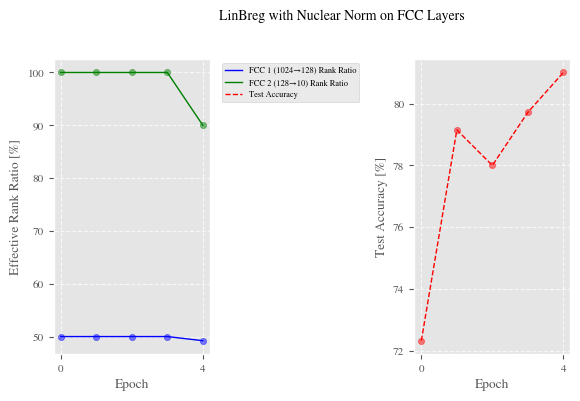

In [12]:
# Create a figure with 1x2 subplots (rank ratio and accuracy)
fig, ax = plt.subplots(1, 2)
ax = np.ravel(ax)  # Convert to 1D array for consistent indexing

# Create arrays for plotting
x = np.array(range(conf.epochs))

# Dictionary to map layer names to more descriptive labels
layer_display_names = {
    'layers2.0': 'FCC 1 (1024→128)',  # First fully connected layer
    'layers2.2': 'FCC 2 (128→10)'     # Second fully connected layer
}

# Plot effective rank ratio for each layer in first subplot - different colors
colors = ['blue', 'green', 'purple', 'orange', 'brown', 'pink']
for i, (layer_name, history) in enumerate(effective_rank_histories.items()):
    color = colors[i % len(colors)]
    # Get descriptive name or use original if not in the dictionary
    display_name = layer_display_names.get(layer_name, layer_name)
    # Convert to percentage
    history_percent = [val * 100 for val in history]
    ax[0].plot(x, history_percent, linestyle='-', color=color, label=f'{display_name} Rank Ratio')
    ax[0].scatter(x, history_percent, color=color, s=20, alpha=0.5)

# Plot test accuracy in second subplot - as before
# Convert to percentage
test_accuracy_percent = [acc * 100 for acc in test_accuracy_history]
ax[1].plot(x, test_accuracy_percent, linestyle='--', color='red', label='Test Accuracy')
ax[1].scatter(x, test_accuracy_percent, color='red', s=20, alpha=0.5)

# Specify axes
## Effective Rank Ratio
ax[0].set_ylabel('Effective Rank Ratio [%]')
ax[0].set_xlabel('Epoch')
ax[0].grid(True, linestyle='--', alpha=0.7)

## Test Accuracy
ax[1].set_ylabel('Test Accuracy [%]')
ax[1].set_xlabel('Epoch')
ax[1].grid(True, linestyle='--', alpha=0.7)

# Modify x-axis to show labels at multiples of 5 for both subplots
max_epoch = len(x) - 1
xticks = [i for i in range(0, max_epoch+1, 5)]
if max_epoch not in xticks:
    xticks.append(max_epoch)
ax[0].set_xticks(xticks)
ax[1].set_xticks(xticks)

# Get legend handles from both plots
handles = []
labels = []
for i in range(len(ax)):
    h, l = ax[i].get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Add a legend to the first subplot but position it outside
ax[0].legend(handles, labels, loc='upper left', bbox_to_anchor=(1.05, 1), prop={'size': 6}, ncol=1)

# Adjust size and title
width = 5.50107 / 0.8
height = 8.02778 / (2.0)
fig.set_size_inches(width, height)
fig.suptitle('LinBreg with Nuclear Norm on FCC Layers', fontsize=10)

# Adjust layout to make space for the legend
plt.tight_layout(rect=[0, 0, 0.85, 0.95])  # Adjust for legend space

plt.show()